<a href="https://colab.research.google.com/github/shryu8902/KIRD_AUTOML/blob/main/KIRD_Day_1_3_ML_%EB%AA%A8%EB%8D%B8_%ED%94%84%EB%A1%9C%EC%84%B8%EC%8A%A4_%EB%B3%84_%EC%9E%90%EB%8F%99%ED%99%94_%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC_%ED%99%9C%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. 데이터 전처리 및 피쳐 엔지니어링

이번 실습에서는 이전 예제와 마찬가지로 타이타닉 생존자 데이터셋으로 머신러닝 모델 개발과정에서 각 단계별 특화된 자동화 라이브러리를 활용해보도록하겠습니다.
먼저 데이터 전처리 및 피쳐엔지니어링을 위해 ```feature-engine``` 라이브러리를 활용해보겠습니다.


## 0. 데이터 및 라이브러리 준비

In [ ]:
import pandas as pd
!pip install feature_engine
!wget https://raw.githubusercontent.com/shryu8902/KIRD_AUTOML/main/Titanic-Dataset.csv
titanic_data = pd.read_csv('./Titanic-Dataset.csv')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.6/326.6 kB 7.5 MB/s eta 0:00:00
--2023-06-30 04:38:26--  https://raw.githubusercontent.com/shryu8902/KIRD_AUTOML/main/Titanic-Dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61194 (60K) [text/plain]
Saving to: ‘Titanic-Dataset.csv’

Titanic-Dataset.csv 100%[===================>]  59.76K  --.-KB/s    in 0.007s  

2023-06-30 04:38:26 (8.13 MB/s) - ‘Titanic-Dataset.csv’ saved [61194/61194]



In [ ]:
titanic_data.drop(['PassengerId','Cabin','Name'],axis = 1, inplace=True)

titanic_data.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      2
dtype: int64

In [ ]:
titanic_data.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S


## 1. 누락값 처리
- ```DropMissingData``` : 누락값을 포함한 row를 제거. threshold 로 전체 변수중 NA 값의 비율에 따라 row 제외.
- ```MeanMedianImputer``` : 평균 또는 중앙값으로 누락값 대체
- ```CategoricalImputer``` : categorical 변수 (type ‘object’ or ‘categorical’)를 최빈값 또는 임의의 값으로 대체
- ```AddMissingIndicator``` : missing value에 대한 indicator binary variable 생성, 변수명_na 컬럼 추가.

In [ ]:
from feature_engine.imputation import DropMissingData

imputer = DropMissingData(variables=['Age', 'Embarked'])
imputed_data = imputer.fit_transform(titanic_data)
print(imputed_data.isna().sum())

print('raw data shape', titanic_data.shape)
print('proccessed data shape', imputed_data.shape)

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64
raw data shape (891, 9)
proccessed data shape (712, 9)


In [ ]:
from feature_engine.imputation import MeanMedianImputer

imputer = MeanMedianImputer(imputation_method='median', variables=['Age'])
imputed_data = imputer.fit_transform(titanic_data)
imputed_data.Age[titanic_data.Age.isna()]

5      28.0
17     28.0
19     28.0
26     28.0
28     28.0
       ... 
859    28.0
863    28.0
868    28.0
878    28.0
888    28.0
Name: Age, Length: 177, dtype: float64

In [ ]:
from feature_engine.imputation import CategoricalImputer

imputer = CategoricalImputer('frequent', variables=['Embarked']) # frequent : 최빈값, missing : 주어진 설정값으로.
imputed_data = imputer.fit_transform(titanic_data)
imputed_data.Embarked[titanic_data.Embarked.isna()]

61     S
829    S
Name: Embarked, dtype: object

In [ ]:
from feature_engine.imputation import AddMissingIndicator

imputer = AddMissingIndicator(variables=['Age','Embarked'])
imputed_data = imputer.fit_transform(titanic_data)
print(imputed_data.columns)
print(imputed_data.Embarked_na[titanic_data.Embarked.isna()])
print(imputed_data.Age_na[titanic_data.Age.isna()][:5])

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Embarked', 'Age_na', 'Embarked_na'],
      dtype='object')
61     1
829    1
Name: Embarked_na, dtype: int64
5     1
17    1
19    1
26    1
28    1
Name: Age_na, dtype: int64


## 2. 카테고리컬 인코딩 (Categorical encoding)
변수가 아닌 클래스 이름 등으로 구성된 카테코리컬 데이터를 숫자 (벡터)로 변환해주는 함수들.

- ```OneHotEncoder``` : 카테고리컬 변수에 대해 원핫 인코딩 수행.
- ```OrdinalEncoder``` : 카테고리컬 변수를 정수로 인코딩

In [ ]:
titanic_data.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Embarked     object
dtype: object

In [ ]:
from feature_engine.encoding import OneHotEncoder

encoder = OneHotEncoder(
    variables=['Sex', 'Pclass'],
    ignore_format=True, # object, categorical 이외의 데이터에 대한 원핫인코딩 가능
    )

trans_data = encoder.fit_transform(titanic_data)
print(trans_data.head(3))

   Survived   Age  SibSp  Parch            Ticket     Fare Embarked  Sex_male  \
0         0  22.0      1      0         A/5 21171   7.2500        S         1   
1         1  38.0      1      0          PC 17599  71.2833        C         0   
2         1  26.0      0      0  STON/O2. 3101282   7.9250        S         0   

   Sex_female  Pclass_3  Pclass_1  Pclass_2  
0           0         1         0         0  
1           1         0         1         0  
2           1         1         0         0  


In [ ]:
from feature_engine.encoding import OrdinalEncoder

encoder = OrdinalEncoder(
    encoding_method='arbitrary',
    variables=['Sex','Ticket'],
    )

trans_data = encoder.fit_transform(titanic_data)
print(trans_data.head(3))

   Survived  Pclass  Sex   Age  SibSp  Parch  Ticket     Fare Embarked
0         0       3    0  22.0      1      0       0   7.2500        S
1         1       1    1  38.0      1      0       1  71.2833        C
2         1       3    1  26.0      0      0       2   7.9250        S


## 3. 이산화 (Discretization) / Binning
연속형, 수치형 변수들을 정수 클래스로 이산화

- ```EqualFrequencyDiscretiser``` : 주어진 bin에 따라서 같은 비율로 맞추도록 정수 클래스로 변환.
- ```EqualWidthDiscretiser``` : 등간격으로 bin 생성 후 정수 클래스로 변환
- ```ArbitraryDiscretiser``` : 주어진 임의의 범위 순으로 정수 클래스로 변환

In [ ]:
from feature_engine.discretisation import EqualFrequencyDiscretiser

discretizer = EqualFrequencyDiscretiser(
    variables=['Fare'],
    q=10
    )

trans_data = discretizer.fit_transform(titanic_data)
print(trans_data.head(3))

   Survived  Pclass     Sex   Age  SibSp  Parch            Ticket  Fare  \
0         0       3    male  22.0      1      0         A/5 21171     0   
1         1       1  female  38.0      1      0          PC 17599     8   
2         1       3  female  26.0      0      0  STON/O2. 3101282     2   

  Embarked  
0        S  
1        C  
2        S  


<Axes: >

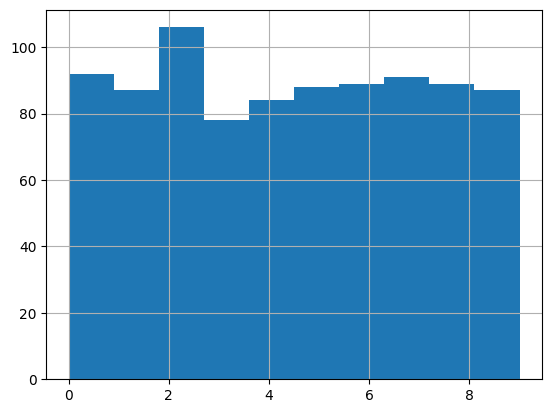

In [ ]:
trans_data.Fare.hist()

In [ ]:
from feature_engine.discretisation import EqualWidthDiscretiser

discretizer = EqualWidthDiscretiser(
    variables=['Fare'],
    bins=10
    )

trans_data = discretizer.fit_transform(titanic_data)
print(trans_data.head(3))

   Survived  Pclass     Sex   Age  SibSp  Parch            Ticket  Fare  \
0         0       3    male  22.0      1      0         A/5 21171     0   
1         1       1  female  38.0      1      0          PC 17599     1   
2         1       3  female  26.0      0      0  STON/O2. 3101282     0   

  Embarked  
0        S  
1        C  
2        S  


<Axes: >

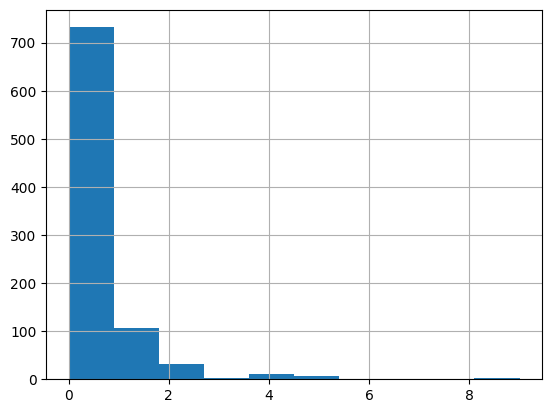

In [ ]:
trans_data.Fare.hist()

In [ ]:
from feature_engine.discretisation import ArbitraryDiscretiser

discretizer = ArbitraryDiscretiser(
    binning_dict = {'Fare' :[0,10,100,1000]}, ## 기존 variable이 binning_dict안으로 들어감
    )

trans_data = discretizer.fit_transform(titanic_data)
print(trans_data.head(3))

   Survived  Pclass     Sex   Age  SibSp  Parch            Ticket  Fare  \
0         0       3    male  22.0      1      0         A/5 21171     0   
1         1       1  female  38.0      1      0          PC 17599     1   
2         1       3  female  26.0      0      0  STON/O2. 3101282     0   

  Embarked  
0        S  
1        C  
2        S  


<Axes: >

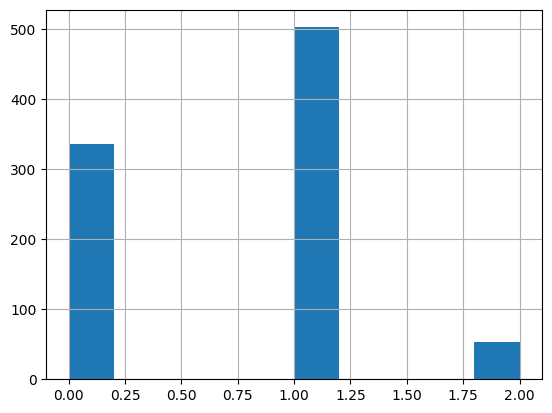

In [ ]:
trans_data.Fare.hist()

## 4. 아웃라이어 처리
아웃라이어/이상값 처리

- ```Winsorizer``` : numerical variables에 대해 조건에 따라서 극단값 제한. e.g., 가우시안 : 평균+-3표준편차, IQR : 박스플롯 아웃라이어 처리
- ```ArbitraryOutlierCapper``` : 임의의 기준값 이상/이하인 값으로 제한.
- ```OutlierTrimmer``` : Winsorizer와 유사하나 극단값을 제한이 아닌 제외함.

In [ ]:
# Winsorizer by gaussian
from feature_engine.outliers import Winsorizer

outlier_remover = Winsorizer(
    variables = ['Age'],
    capping_method = 'gaussian',
    tail = 'both', # 'right', 'left','both'
    fold = 1, # std scale
    missing_values = 'ignore'
    )

removed_data = outlier_remover.fit_transform(titanic_data)

print('Age range before capping', titanic_data.Age.min(), titanic_data.Age.max())
print('Age range after capping',removed_data.Age.min(), removed_data.Age.max())

Age range before capping 0.42 80.0
Age range after capping 15.182796496241505 44.21543879787613


In [ ]:
# Winsorizer by quantiles

outlier_remover = Winsorizer(
    variables = ['Age'],
    capping_method = 'quantiles',
    tail = 'both', # 'right', 'left','both'
    fold = 0.05, # std scale
    missing_values = 'ignore'
    )

removed_data = outlier_remover.fit_transform(titanic_data)
print('Age range before capping', titanic_data.Age.min(), titanic_data.Age.max())
print('Age range after capping',removed_data.Age.min(), removed_data.Age.max())

Age range before capping 0.42 80.0
Age range after capping 4.0 56.0


In [ ]:
# Outlier Trimmer by gaussian
from feature_engine.outliers import OutlierTrimmer

outlier_remover = OutlierTrimmer(
    variables = ['Age'],
    capping_method = 'gaussian',
    tail = 'both', # 'right', 'left','both'
    fold = 1, # std scale
    missing_values = 'ignore'
    )

removed_data = outlier_remover.fit_transform(titanic_data)
print(len(removed_data))
print(removed_data.isna().sum())

516
Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    1
dtype: int64


## 5. 피쳐 생성
기존의 변수를 바탕으로 새로운 feature (variable) 생성

- ```Winsorizer``` : numerical variables에 대해 조건에 따라서 극단값 제한. e.g., 가우시안 : 평균+-3표준편차, IQR : 박스플롯 아웃라이어 처리
- ```RelativeFeatures``` : 주어진 변수와 레퍼런스 변수 사이에서의 연산 사칙연산 등 수행
- ```CyclicalFeatures``` : sin/cos(variable * (2. * pi / max_value)) 변환 수행
----------------------------------------------------------
- ```PolynomialFeatures``` : Scikit-learn 제공, numerical 변수들에 대한 polynomial 조합 생성

In [ ]:
from feature_engine.creation import MathFeatures

feature_creator = MathFeatures(
    variables = ['SibSp','Parch'],
    func = "sum", # sum, prod, mean, max, min, etc.
    missing_values = 'ignore'
    )

new_data = feature_creator.fit_transform(titanic_data)
print(new_data.columns)
print(new_data.head(3))

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Embarked', 'sum_SibSp_Parch'],
      dtype='object')
   Survived  Pclass     Sex   Age  SibSp  Parch            Ticket     Fare  \
0         0       3    male  22.0      1      0         A/5 21171   7.2500   
1         1       1  female  38.0      1      0          PC 17599  71.2833   
2         1       3  female  26.0      0      0  STON/O2. 3101282   7.9250   

  Embarked  sum_SibSp_Parch  
0        S                1  
1        C                1  
2        S                0  


In [ ]:
# Numerical feature만 조합가능.
# scikit-learn 라이브러리 활용
from sklearn.preprocessing import PolynomialFeatures

feature_creator = PolynomialFeatures(
    degree = 2,
    interaction_only = True,
    )

new_data = feature_creator.fit_transform(titanic_data[['Fare','SibSp','Parch']])

print(feature_creator.get_feature_names_out(['Fare','SibSp','Parch']))
print(new_data[:3,:])

['1' 'Fare' 'SibSp' 'Parch' 'Fare SibSp' 'Fare Parch' 'SibSp Parch']
[[ 1.      7.25    1.      0.      7.25    0.      0.    ]
 [ 1.     71.2833  1.      0.     71.2833  0.      0.    ]
 [ 1.      7.925   0.      0.      0.      0.      0.    ]]


## 6. 연습
위의 기법 등을 활용해서 전처리가 완료된 타이타닉 데이터셋을 생성해봅니다.

In [ ]:
imputer = DropMissingData(variables=['Age', 'Embarked'])
imputed_data = imputer.fit_transform(titanic_data)
encoder = OrdinalEncoder(
    encoding_method='arbitrary',
    variables=['Sex','Embarked'],
    )
trans_data = encoder.fit_transform(imputed_data)
data = trans_data.drop(['Ticket'],axis=1)

In [ ]:
data.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0


#2. 임밸런스 데이터

이번 실습에서는 임밸런스 데이터를 다루기 위한 imbalanced-learn의 기능들을 실습해보도록하겠습니다.
학습데이터 내의 클래스의 비율을 맞춰주기 위한 것이기때문에, 사전에 클래스에 대한 변수를 필요로 합니다.

In [ ]:
# 라이브러리 다운로드
!pip install imbalanced-learn

<Axes: >

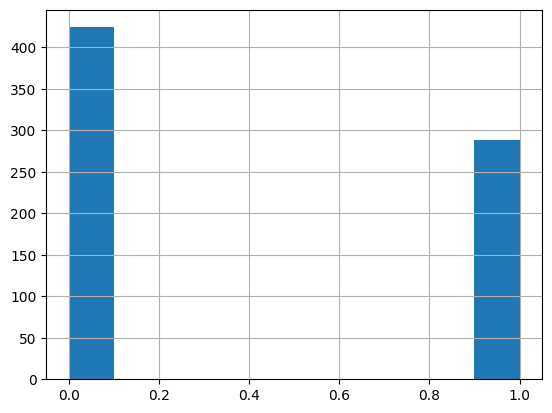

In [ ]:
# 타이타닉 생존자 비율
data.Survived.hist()

<Axes: >

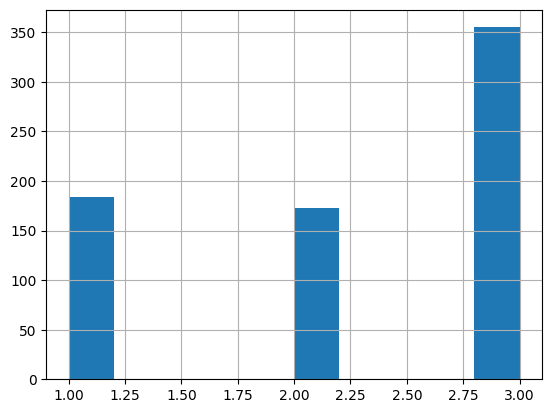

In [ ]:
# 타이타닉 생존자 비율
data.Pclass.hist()

## 1. Undersampling

```RandomUnderSampler``` : 주류 클래스 데이터를 랜덤하게 샘플링하여 숫자를 줄임.


<Axes: >

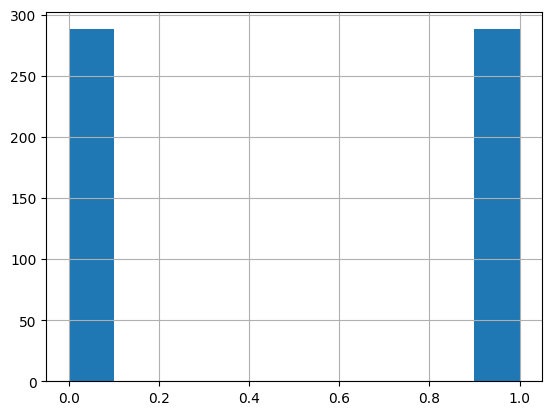

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Binary class의 경우
sampler = RandomUnderSampler(random_state=0)
sampled_df, sampled_lable = sampler.fit_resample(data, data.Survived)

sampled_df.Survived.hist()

<Axes: >

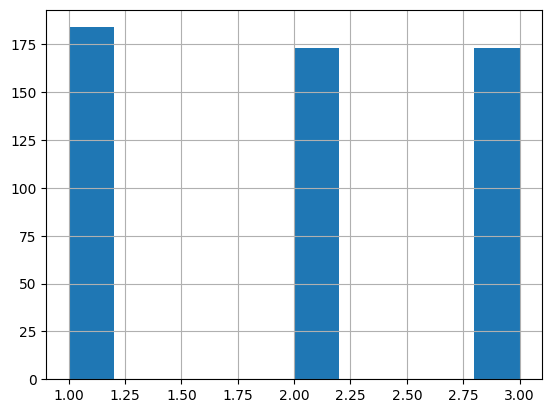

In [ ]:
# Multiclass의 경우
sampler = RandomUnderSampler(random_state=0, sampling_strategy = 'majority') #
sampled_df, sampled_lable = sampler.fit_resample(data, data.Pclass)

sampled_df.Pclass.hist()

## 1. Oversampling

오버샘플링은 소수 클래스의 데이터 숫자를 늘려줍니다. data augmentation을 위해 살용할 수 있습니다.

```RandomOverSampler``` : 비주류 클래스 데이터를 랜덤하게 샘플링하여 숫자를 늘림.
```SMOTE```: Synthetic Minority Over-sampling , K-NN을 활용하여 신규 샘플을 생성.
```ADASYN```: SMOTE와 유사하지만, 분류 경계에 더 많은 소수 클래스 샘플을 생성.


In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Binary class의 경우
sampler = RandomOverSampler(random_state=0)
sampled_df, sampled_lable = sampler.fit_resample(data, data.Survived)

print(sampled_df.groupby('Survived').count())

          Pclass  Sex  Age  SibSp  Parch  Fare  Embarked
Survived                                                
0            424  424  424    424    424   424       424
1            424  424  424    424    424   424       424


In [ ]:
sampler = RandomOverSampler(random_state=0, sampling_strategy = 'not majority') #
sampled_df, sampled_lable = sampler.fit_resample(data, data.Pclass)

print(sampled_df.groupby('Pclass').count())

        Survived  Sex  Age  SibSp  Parch  Fare  Embarked
Pclass                                                  
1            355  355  355    355    355   355       355
2            355  355  355    355    355   355       355
3            355  355  355    355    355   355       355


In [ ]:
from imblearn.over_sampling import SMOTE

sampler = SMOTE(random_state=0, k_neighbors = 3)
sampled_df, sampled_lable = sampler.fit_resample(data, data.Survived)

print(sampled_df.groupby('Survived').count())

          Pclass  Sex  Age  SibSp  Parch  Fare  Embarked
Survived                                                
0            424  424  424    424    424   424       424
1            424  424  424    424    424   424       424


In [ ]:
# categorical, integer 등을 고려해야할 필요가 있음.
sampled_df[sampled_df.Survived ==1].Age.tail(5)

843    23.289512
844     1.872885
845    40.000000
846    20.051902
847    20.000000
Name: Age, dtype: float64

In [ ]:
from imblearn.over_sampling import ADASYN

sampler = ADASYN(random_state=0, n_neighbors = 5)
sampled_df, sampled_lable = sampler.fit_resample(data, data.Survived)
print(sampled_df.groupby('Survived').count())

          Pclass  Sex  Age  SibSp  Parch  Fare  Embarked
Survived                                                
0            424  424  424    424    424   424       424
1            400  400  400    400    400   400       400


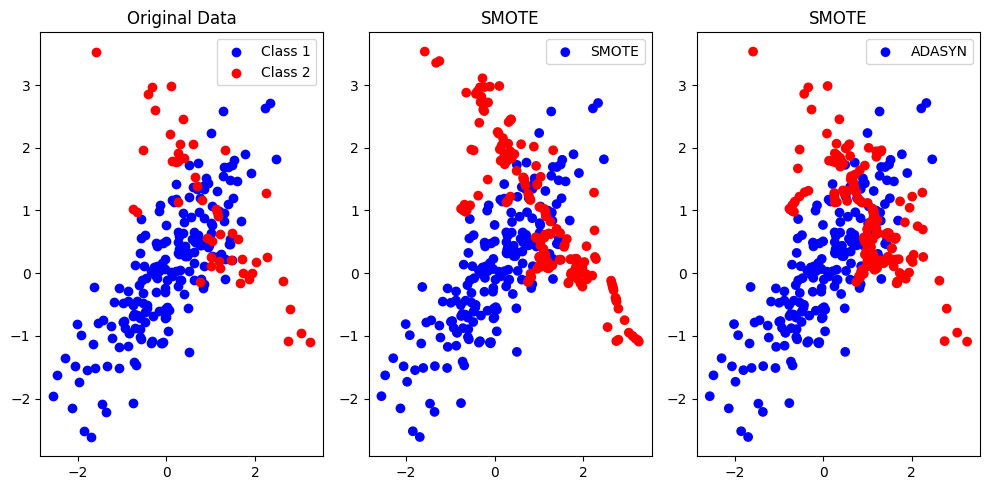

In [ ]:
# SMOTE와 ADASYN의 차이점
import matplotlib.pyplot as plt
import numpy as np
# 2차원 가우시안 변수 분포 생성
np.random.seed(0)
mean1 = [0, 0]
cov1 = [[1, 0.8], [0.8, 1]]
mean2 = [1, 1]
cov2 = [[1, -0.8], [-0.8, 1]]
X1 = np.random.multivariate_normal(mean1, cov1, 200)
X2 = np.random.multivariate_normal(mean2, cov2, 50)

X = np.concatenate([X1,X2])
y = np.concatenate([np.zeros(200),np.ones(50)])
# SMOTE 적용
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

# ADASYN 적용
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

# 데이터 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.scatter(X1[:, 0], X1[:, 1], c='blue', label='Class 1')
plt.scatter(X2[:, 0], X2[:, 1], c='red', label='Class 2')
plt.title('Original Data')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(X_smote[:, 0], X_smote[:, 1], c=['blue' if label == 0 else 'red' for label in y_smote], label='SMOTE')
plt.title('SMOTE')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(X_adasyn[:, 0], X_adasyn[:, 1], c=['blue' if label == 0 else 'red' for label in y_adasyn], label='ADASYN')
plt.title('SMOTE')
plt.legend()

plt.tight_layout()
plt.show()


# 3. 하이퍼 파라미터 최적화 with Optuna

이전 실습자료에서는 scikit-learn 랜덤포레스트 모델과 skopt 라이브러리를 활용하여 모델 탐색 및 하이퍼 파라미터 최적화를 수행하였습니다.  
이번 실습에서는 lightGBM과 optuna를 활용한 모델 학습을 수행해보도록하겠습니다.

## 1. LightGBM 모델 트레이닝

In [ ]:
!pip install lightgbm

In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop('Survived', axis=1)
y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0) # Stratified split 적용


In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score


# LightGBM 모델 설정
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'max_depth' : 3,
    'learning_rate': 0.1,
}

# LightGBM 모델 학습
model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8321678321678322


## 매뉴얼 하이퍼 파라미터 조정.

위의 코드에서 하이퍼 파라미터들을 수정해가면서 Accuracy를 올려보세요.

https://lightgbm.readthedocs.io/en/stable/Parameters-Tuning.html

In [ ]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'max_depth' : 3,
    'learning_rate': 0.1,
}

# LightGBM 모델 학습
model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


## 2. Optuna 활용하기.

>Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, dfine-by-run style user API. Thanks to our define-by-run API, the code written with Optuna enjoys high modularity, and the user of Optuna can dynamically construct the search spaces for the hyperparameters.

Optuna를 활용하기 위한 기초요소는 다음과 같습니다.

- Objective Function: Objective Function은 최적화하려는 대상 함수입니다. 주어진 하이퍼파라미터 조합에 대해 평가되는 함수로, 일반적으로 모델의 학습과 검증을 수행하여 최적화 목표를 제공합니다. Objective Function은 하이퍼파라미터 조합을 받아 해당 조합으로 모델을 학습하고 평가하는 역할을 수행합니다.

- Trial: Trial은 단일 최적화 시도를 나타내는 객체입니다. Trial 객체는 하나의 하이퍼파라미터 조합과 해당 조합에 대한 목적 함수의 평가 결과를 저장합니다.

- Study: Study는 Optuna에서 전체 최적화 과정을 관리하는 객체로 하이퍼파라미터 조합에 대한 성능 추적과 최적화 알고리즘의 실행을 담당합니다. 하나의 Study 객체는 하나의 최적화 작업을 의미하고 여러 개의 Trial 객체를 생성하여 하이퍼파라미터 조합을 탐색하고 평가합니다.

- Trial Suggest: Trial Suggest는 하이퍼파라미터 값을 추천하는 메서드를 제공하는 객체입니다. suggest_uniform, suggest_categorical, suggest_loguniform 등의 메서드를 사용하여 연속형, 범주형, 로그 스케일 등의 하이퍼파라미터 값을 추천할 수 있습니다. Objective Function 내에서 Trial Suggest를 호출하여 추천된 하이퍼파라미터 값을 가져올 수 있습니다.

하이퍼 파라미터 탐색 범위 제안 메서드

- suggest_int(name, low, high): 주어진 범위에서 균등 분포로 정수형 하이퍼파라미터 값을 추천합니다.

- suggest_categorical(name, choices): 주어진 카테고리 리스트 중 하나의 값을 선택하여 범주형 하이퍼파라미터 값을 추천합니다.

- suggest_discrete_uniform(name, low, high, q): 주어진 범위에서 균등 분포로 이산형 하이퍼파라미터 값을 추천합니다.

- suggest_uniform(name, low, high): 주어진 범위에서 균등 분포로 실수형 하이퍼파라미터 값을 추천합니다.

- suggest_loguniform(name, low, high): 주어진 범위에서 로그 균등 분포로 실수형 하이퍼파라미터 값을 추천합니다.


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.4 MB/s eta 0:00:00


In [ ]:
# 라이브러리 불러오기
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import optuna

In [ ]:
# 기본적인 예제
def objective(trial):
    x = trial.suggest_float("x", 0, 10)
    return (x-2)**2

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print(study.best_params)

[I 2023-06-30 04:47:05,615] A new study created in memory with name: no-name-c51911cd-1265-44a5-981b-28b0ff9282ad
[I 2023-06-30 04:47:05,619] Trial 0 finished with value: 17.285370540281537 and parameters: {'x': 6.157567863581007}. Best is trial 0 with value: 17.285370540281537.
[I 2023-06-30 04:47:05,623] Trial 1 finished with value: 0.16402398239781085 and parameters: {'x': 1.5950012563009475}. Best is trial 1 with value: 0.16402398239781085.
[I 2023-06-30 04:47:05,629] Trial 2 finished with value: 0.27196059005492484 and parameters: {'x': 1.4785015915125677}. Best is trial 1 with value: 0.16402398239781085.
[I 2023-06-30 04:47:05,632] Trial 3 finished with value: 56.367731093966405 and parameters: {'x': 9.507844637042405}. Best is trial 1 with value: 0.16402398239781085.
[I 2023-06-30 04:47:05,634] Trial 4 finished with value: 62.51451994209413 and parameters: {'x': 9.906612418861451}. Best is trial 1 with value: 0.16402398239781085.
[I 2023-06-30 04:47:05,636] Trial 5 finished with

{'x': 1.5950012563009475}


### Optuna with LightGBM

In [ ]:
# 목적 함수 구성.
# 목적 함수는 최적화 대상 값을 반환해야합니다. e.g., 점수, 정확도, 로스 등

def objective(trial):
    # 탐색을 위한 범위 설정
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'max_depth' : trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
    }
    # 최적화 대상값 반환을 위한 모델 설정
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Best Accuracy:", accuracy)
print("Best Parameters:", best_params)


[I 2023-06-30 04:51:12,341] A new study created in memory with name: no-name-ab69eb14-c55b-4ee4-8e4b-5ea9d1e63e57
<ipython-input-52-2069f853cd63>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2023-06-30 04:51:12,393] Trial 0 finished with value: 0.8461538461538461 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'max_depth': 10, 'learning_rate': 0.01592759685290768}. Best is trial 0 with value: 0.8461538461538461.
<ipython-input-52-2069f853cd63>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2023-06-30 04:5

Best Accuracy: 0.8951048951048951
Best Parameters: {'boosting_type': 'goss', 'num_leaves': 98, 'max_depth': 3, 'learning_rate': 0.03081361753763389}


In [ ]:
optuna.visualization.plot_param_importances(study)

### Optuna with Scikit-learn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

# 목적 함수 구성
def objective(trial):
    # 탐색을 위한 범위 설정
    model_type = trial.suggest_categorical('model_type', ['KNeighbors', 'DecisionTree', 'RandomForest', 'AdaBoost', 'SVC'])

    if model_type == 'KNeighbors':
        n_neighbors = trial.suggest_int('n_neighbors', 3, 10)
        model = KNeighborsClassifier(n_neighbors=n_neighbors)

    elif model_type == 'DecisionTree':
        max_depth = trial.suggest_int('max_depth', 3, 10)
        model = DecisionTreeClassifier(max_depth=max_depth)

    elif model_type == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)

    elif model_type == 'AdaBoost':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)
        model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate)

    elif model_type == 'SVC':
        C = trial.suggest_loguniform('C', 0.1, 10)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        model = SVC(C=C, kernel=kernel)

    else:
        raise ValueError("Invalid model type!")

    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


# Optuna를 사용한 하이퍼파라미터 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# 최적의 하이퍼파라미터와 정확도 출력
best_params = study.best_params
best_accuracy = study.best_value
print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)


[I 2023-06-30 04:54:13,022] A new study created in memory with name: no-name-1c8021bb-77f6-4abb-886e-01f5687cabe1
[I 2023-06-30 04:54:13,097] Trial 0 finished with value: 0.7482517482517482 and parameters: {'model_type': 'KNeighbors', 'n_neighbors': 3}. Best is trial 0 with value: 0.7482517482517482.
[I 2023-06-30 04:54:15,016] Trial 1 finished with value: 0.8321678321678322 and parameters: {'model_type': 'RandomForest', 'n_estimators': 384, 'max_depth': 10}. Best is trial 1 with value: 0.8321678321678322.
[I 2023-06-30 04:54:15,034] Trial 2 finished with value: 0.8601398601398601 and parameters: {'model_type': 'DecisionTree', 'max_depth': 3}. Best is trial 2 with value: 0.8601398601398601.
<ipython-input-54-ed8baf89b8fa>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 10)
[I 2023-06-30 

Best Parameters: {'model_type': 'DecisionTree', 'max_depth': 3}
Best Accuracy: 0.8601398601398601
